In [3]:
import numpy as np 
import os.path, random 
import torch 
from torch.utils.data import Dataset 
print("Torch version {}".format(torch.__version__))

Torch version 1.9.1+cu111


In [6]:
# get training data 
dir = "./" 
if True: 
    # download 
    if not os.path.isfile('data-airfoils.npz'): 
        import requests 
        print("Downloading training data (300MB), this can take a few minutes the first time...") 
        with open("data-airfoils.npz", 'wb') as datafile: 
            resp = requests.get('https://dataserv.ub.tum.de/s/m1615239/download?path=%2F&files=dfp-data-400.npz', verify=False) 
            datafile.write(resp.content)
else: 
    # alternative: load from google drive (upload there beforehand): 
    from google.colab import drive 
    drive.mount('/content/gdrive') 
    dir = "./gdrive/My Drive/"

C:\Program Files\Python39\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dataserv.ub.tum.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [7]:
npfile=np.load(dir+'data-airfoils.npz')
print("Loaded data, {} training, {} validation samples".format(len(npfile["inputs"]),len(npfile["vinputs"]))) 
print("Size of the inputs array: "+format(npfile["inputs"].shape))

Loaded data, 320 training, 80 validation samples
Size of the inputs array: (320, 3, 128, 128)


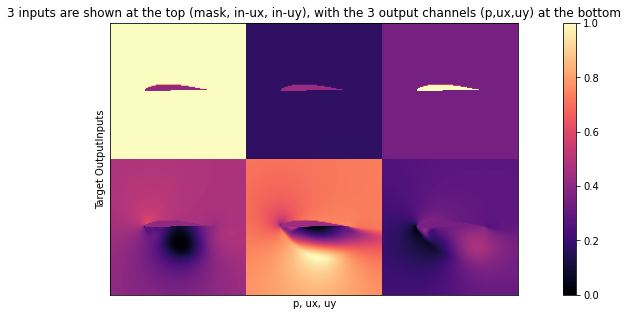

In [9]:
import pylab
# helper to show three target channels: normalized, with colormap, side by side 
def showSbs(a1,a2, stats=False, bottom="NN Output", top="Reference", title=None): 
    c=[] 
    for i in range(3): 
        b = np.flipud( np.concatenate((a2[i],a1[i]),axis=1).transpose()) 
        min, mean, max = np.min(b), np.mean(b), np.max(b); 
        if stats:  print("Stats %d: "%i + format([min,mean,max])) 
        b -= min; b /= (max-min) 
        c.append(b)
    fig, axes = pylab.subplots(1, 1, figsize=(16, 5)) 
    axes.set_xticks([]); axes.set_yticks([]); 
    im = axes.imshow(np.concatenate(c,axis=1), origin='upper', cmap='magma')
    pylab.colorbar(im); pylab.xlabel('p, ux, uy'); pylab.ylabel('%s%s'%(bottom,top)) 
    if title is not None: pylab.title(title)

NUM=72
showSbs(npfile["inputs"][NUM],npfile["targets"][NUM], stats=False, bottom="Target Output", top="Inputs", title="3 inputs are shown at the top (mask, in-ux, in-uy), with the 3 output channels (p,ux,uy) at the bottom")

In [10]:
# some global training constants

# number of training epochs
EPOCHS = 100
# batch size
BATCH_SIZE = 10
# learning rate
LR = 0.00002

class DfpDataset():
    def __init__(self, inputs,targets): 
        self.inputs  = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

tdata = DfpDataset(npfile["inputs"],npfile["targets"])
vdata = DfpDataset(npfile["vinputs"],npfile["vtargets"])

trainLoader = torch.utils.data.DataLoader(tdata, batch_size=BATCH_SIZE, shuffle=True , drop_last=True) 
valiLoader  = torch.utils.data.DataLoader(vdata, batch_size=BATCH_SIZE, shuffle=False, drop_last=True) 

print("Training & validation batches: {} , {}".format(len(trainLoader),len(valiLoader) ))

Training & validation batches: 32 , 8


In [11]:
import os, sys, random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd 
import torch.utils.data 

def blockUNet(in_c, out_c, name, transposed=False, bn=True, relu=True, size=4, pad=1, dropout=0.):
    block = nn.Sequential()

    if relu:
        block.add_module('%s_relu' % name, nn.ReLU(inplace=True))
    else:
        block.add_module('%s_leakyrelu' % name, nn.LeakyReLU(0.2, inplace=True))

    if not transposed:
        block.add_module('%s_conv' % name, nn.Conv2d(in_c, out_c, kernel_size=size, stride=2, padding=pad, bias=True))
    else:
        block.add_module('%s_upsam' % name, nn.Upsample(scale_factor=2, mode='bilinear'))
        # reduce kernel size by one for the upsampling (ie decoder part)
        block.add_module('%s_tconv' % name, nn.Conv2d(in_c, out_c, kernel_size=(size-1), stride=1, padding=pad, bias=True))

    if bn:
        block.add_module('%s_bn' % name, nn.BatchNorm2d(out_c))
    if dropout>0.:
        block.add_module('%s_dropout' % name, nn.Dropout2d( dropout, inplace=True))

    return block
    
class DfpNet(nn.Module):
    def __init__(self, channelExponent=6, dropout=0.):
        super(DfpNet, self).__init__()
        channels = int(2 ** channelExponent + 0.5)

        self.layer1 = nn.Sequential()
        self.layer1.add_module('layer1', nn.Conv2d(3, channels, 4, 2, 1, bias=True))

        self.layer2 = blockUNet(channels  , channels*2, 'enc_layer2', transposed=False, bn=True, relu=False, dropout=dropout )
        self.layer3 = blockUNet(channels*2, channels*2, 'enc_layer3', transposed=False, bn=True, relu=False, dropout=dropout )
        self.layer4 = blockUNet(channels*2, channels*4, 'enc_layer4', transposed=False, bn=True, relu=False, dropout=dropout )
        self.layer5 = blockUNet(channels*4, channels*8, 'enc_layer5', transposed=False, bn=True, relu=False, dropout=dropout ) 
        self.layer6 = blockUNet(channels*8, channels*8, 'enc_layer6', transposed=False, bn=True, relu=False, dropout=dropout , size=2,pad=0)
        self.layer7 = blockUNet(channels*8, channels*8, 'enc_layer7', transposed=False, bn=True, relu=False, dropout=dropout , size=2,pad=0)
     
        # note, kernel size is internally reduced by one for the decoder part
        self.dlayer7 = blockUNet(channels*8, channels*8, 'dec_layer7', transposed=True, bn=True, relu=True, dropout=dropout , size=2,pad=0)
        self.dlayer6 = blockUNet(channels*16,channels*8, 'dec_layer6', transposed=True, bn=True, relu=True, dropout=dropout , size=2,pad=0)
        self.dlayer5 = blockUNet(channels*16,channels*4, 'dec_layer5', transposed=True, bn=True, relu=True, dropout=dropout ) 
        self.dlayer4 = blockUNet(channels*8, channels*2, 'dec_layer4', transposed=True, bn=True, relu=True, dropout=dropout )
        self.dlayer3 = blockUNet(channels*4, channels*2, 'dec_layer3', transposed=True, bn=True, relu=True, dropout=dropout )
        self.dlayer2 = blockUNet(channels*4, channels  , 'dec_layer2', transposed=True, bn=True, relu=True, dropout=dropout )

        self.dlayer1 = nn.Sequential()
        self.dlayer1.add_module('dec_layer1_relu', nn.ReLU(inplace=True))
        self.dlayer1.add_module('dec_layer1_tconv', nn.ConvTranspose2d(channels*2, 3, 4, 2, 1, bias=True))

    def forward(self, x):
        # note, this Unet stack could be allocated with a loop, of course... 
        out1 = self.layer1(x)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)
        out5 = self.layer5(out4)
        out6 = self.layer6(out5)
        out7 = self.layer7(out6)
        # ... bottleneck ...
        dout6 = self.dlayer7(out7)
        dout6_out6 = torch.cat([dout6, out6], 1)
        dout6 = self.dlayer6(dout6_out6)
        dout6_out5 = torch.cat([dout6, out5], 1)
        dout5 = self.dlayer5(dout6_out5)
        dout5_out4 = torch.cat([dout5, out4], 1)
        dout4 = self.dlayer4(dout5_out4)
        dout4_out3 = torch.cat([dout4, out3], 1)
        dout3 = self.dlayer3(dout4_out3)
        dout3_out2 = torch.cat([dout3, out2], 1)
        dout2 = self.dlayer2(dout3_out2)
        dout2_out1 = torch.cat([dout2, out1], 1)
        dout1 = self.dlayer1(dout2_out1)
        return dout1

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [12]:
# channel exponent to control network size
EXPO = 3

# setup network
net = DfpNet(channelExponent=EXPO)
#print(net) # to double check the details...

nn_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in nn_parameters])

# crucial parameter to keep in view: how many parameters do we have?
print("Trainable params: {}   -> crucial! always keep in view... ".format(params)) 

net.apply(weights_init)

criterionL1 = nn.L1Loss()
optimizerG = optim.Adam(net.parameters(), lr=LR, betas=(0.5, 0.999), weight_decay=0.0)

targets = torch.autograd.Variable(torch.FloatTensor(BATCH_SIZE, 3, 128, 128))
inputs  = torch.autograd.Variable(torch.FloatTensor(BATCH_SIZE, 3, 128, 128))

Trainable params: 147683   -> crucial! always keep in view... 


In [13]:
history_L1 = []
history_L1val = []

if os.path.isfile("network"):
  print("Found existing network, loading & skipping training")
  net.load_state_dict(torch.load("network")) # optionally, load existing network

else:
  print("Training from scratch")
  for epoch in range(EPOCHS):
      net.train()
      L1_accum = 0.0
      for i, traindata in enumerate(trainLoader, 0):
          inputs_curr, targets_curr = traindata
          inputs.data.copy_(inputs_curr.float())
          targets.data.copy_(targets_curr.float())

          net.zero_grad()
          gen_out = net(inputs)

          lossL1 = criterionL1(gen_out, targets)
          lossL1.backward()
          optimizerG.step()
          L1_accum += lossL1.item()

      # validation
      net.eval()
      L1val_accum = 0.0
      for i, validata in enumerate(valiLoader, 0):
          inputs_curr, targets_curr = validata
          inputs.data.copy_(inputs_curr.float())
          targets.data.copy_(targets_curr.float())

          outputs = net(inputs)
          outputs_curr = outputs.data.cpu().numpy()

          lossL1val = criterionL1(outputs, targets)
          L1val_accum += lossL1val.item()

      # data for graph plotting
      history_L1.append( L1_accum / len(trainLoader) )
      history_L1val.append( L1val_accum / len(valiLoader) )

      if epoch<3 or epoch%20==0:
          print( "Epoch: {}, L1 train: {:7.5f}, L1 vali: {:7.5f}".format(epoch, history_L1[-1], history_L1val[-1]) )

  torch.save(net.state_dict(), "network" )
  print("Training done, saved network")

Training from scratch


C:\Program Files\Python39\lib\site-packages\torch\nn\functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


Epoch: 0, L1 train: 0.26036, L1 vali: 0.25091
Epoch: 1, L1 train: 0.24920, L1 vali: 0.24592
Epoch: 2, L1 train: 0.23958, L1 vali: 0.23557
Epoch: 20, L1 train: 0.10538, L1 vali: 0.09877
Epoch: 40, L1 train: 0.04351, L1 vali: 0.04056
Epoch: 60, L1 train: 0.03763, L1 vali: 0.03125
Epoch: 80, L1 train: 0.03496, L1 vali: 0.02857
Training done, saved network


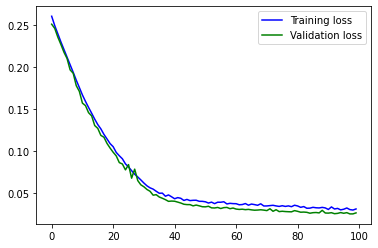

In [14]:
import matplotlib.pyplot as plt

l1train = np.asarray(history_L1)
l1vali  = np.asarray(history_L1val)

plt.plot(np.arange(l1train.shape[0]),l1train,'b',label='Training loss')
plt.plot(np.arange(l1vali.shape[0] ),l1vali ,'g',label='Validation loss')
plt.legend()
plt.show()

C:\Program Files\Python39\lib\site-packages\torch\nn\functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


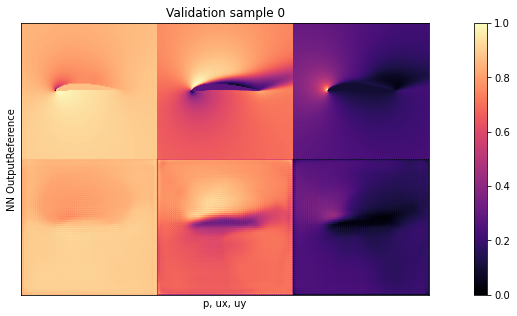

In [15]:
net.eval()
for i, validata in enumerate(valiLoader, 0):
    inputs_curr, targets_curr = validata
    inputs.data.copy_(inputs_curr.float())
    targets.data.copy_(targets_curr.float())
    
    outputs = net(inputs)
    outputs_curr = outputs.data.cpu().numpy()
    if i<1: showSbs(targets_curr[0] , outputs_curr[0], title="Validation sample %d"%(i*BATCH_SIZE))

Loaded 10/10 test samples


Average test error: 0.032508984208106995


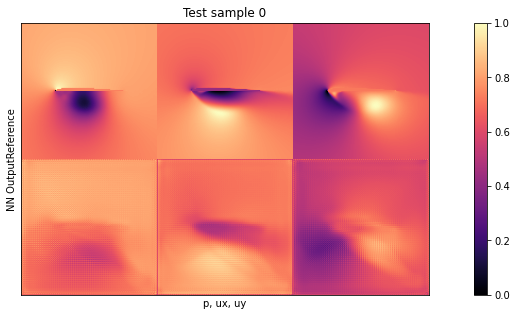

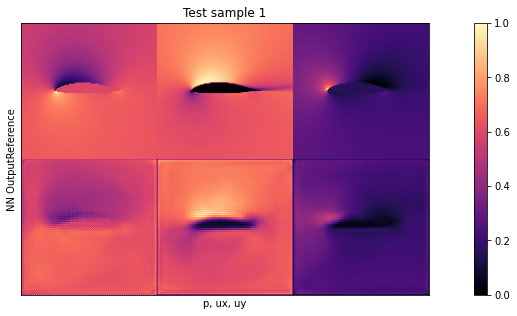

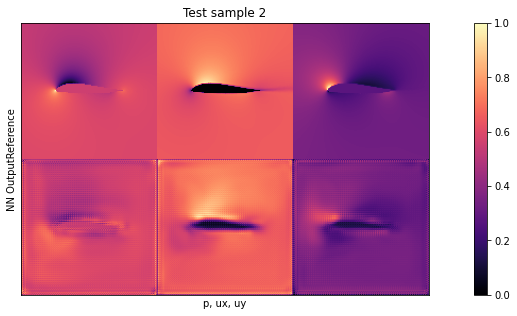

In [16]:
if not os.path.isfile('data-airfoils-test.npz'):
  import urllib.request
  url="https://physicsbaseddeeplearning.org/data/data_test.npz"
  print("Downloading test data, this should be fast...")
  urllib.request.urlretrieve(url, 'data-airfoils-test.npz')

nptfile=np.load('data-airfoils-test.npz')
print("Loaded {}/{} test samples\n".format(len(nptfile["test_inputs"]),len(nptfile["test_targets"])))

testdata = DfpDataset(nptfile["test_inputs"],nptfile["test_targets"])
testLoader  = torch.utils.data.DataLoader(testdata, batch_size=1, shuffle=False, drop_last=True) 

net.eval()
L1t_accum = 0.
for i, validata in enumerate(testLoader, 0):
    inputs_curr, targets_curr = validata
    inputs.data.copy_(inputs_curr.float())
    targets.data.copy_(targets_curr.float())

    outputs = net(inputs)
    outputs_curr = outputs.data.cpu().numpy()

    lossL1t = criterionL1(outputs, targets)
    L1t_accum += lossL1t.item()
    if i<3: showSbs(targets_curr[0] , outputs_curr[0],  title="Test sample %d"%(i))

print("\nAverage test error: {}".format( L1t_accum/len(testLoader) ))